In [1]:
# imports
import sys
import random
import operator 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 

from collections import defaultdict 

# import geos-specific classes
sys.path.append('../module')

from geos import *

In [2]:
plt.rcParams['font.family'] = 'monospace'

In [3]:
# state macros 

## request
REQUEST_SUBMITTED = "submitted"

## solver
SOLVER_BREAKDOWN = "breakdown"
SOLVER_MATCHMAKING = "matchmaking"
SOLVER_VALIDATION = "validation"

## receipts
RECEIPT_DONOR = "donor"
RECEIPT_REQUESTOR = "requestor"

## agents & solvers
SOLVER_TYPES = ["breakdown", "matchmaking", "validation"]
AGENT_TYPES = ["decentralization-conscious", "honest", "rational"]

In [142]:
# initialization data

MAX_QTY_RESOURCES = 10000
COUNT_RESOURCES = 20

system_params = {
    'need_threshold': [0.8],
    'count_economies': 5, 
    'count_agents': 50,
    'count_solvers': 5,
    'count_resources': COUNT_RESOURCES, 
    'count_resource_dependencies': 5,
    'max_qty_resources': 200, #MAX_QTY_RESOURCES,
    'min_qty_resources': 50,
    'max_resource_count_agent': 20,#50,
    'min_resource_count_agent': 10,#20,
    'max_qty_resources_agent': 0.0001 * MAX_QTY_RESOURCES,
    'count_resources_1': int(0.3 * COUNT_RESOURCES),
    'count_resources_2': int(0.7 * COUNT_RESOURCES),
    'agent_types_probabilities': [0.1, 0.4, 0.5], # decentralization-conscious, honest, rational
    'solver_types_probabilities': [0.3, 0.7], # [0, 1] set whether the solver is global
    'resource_dependency_probabilities': [0.95, 0.05] # 
}


In [143]:
# initialize variables

economies = ["econ_" + str(i) for i in range(system_params['count_economies'])]

agents = init_agents(economies, system_params['count_agents'], system_params['agent_types_probabilities'])
solvers = init_solvers(economies, system_params['count_solvers'], system_params['solver_types_probabilities'])

inventory = Inventory()
resources = init_resources(system_params['count_resources_1'], system_params['count_resources_2'], system_params['resource_dependency_probabilities'])

for resource_id, resource in resources.items():
    quantity = random.randint(system_params['min_qty_resources'], system_params['max_qty_resources'])
    inventory.add_resource(resource_id, resource, quantity, quantity) # full stock availability


agents, inventory = distribute_inventory(agents, system_params['min_resource_count_agent'], system_params['max_resource_count_agent'], inventory) #,system_params['max_qty_resources_agent'])
idling_capacity_overall, idling_capacity_by_resource = calculate_cumulative_idling_capacity(inventory, agents)

In [144]:
def cindex(resource_id, net):
   
    stock_per_agent = []
    fraction_per_agent = []

    for agent_id, agent in net.items():
        if resource_id in agent.inventory.stock.keys():
            stock_per_agent.append(agent.inventory.stock[resource_id]["quantity"])

    total_stock = sum(stock_per_agent)
    
    if total_stock == 0:
        return 0.0
    
    for s in stock_per_agent:
        fraction_per_agent.append(s / total_stock)

   # print(fraction_per_agent)
    concentration_index = 1.0 - (max(fraction_per_agent) - min(fraction_per_agent))

    return round(concentration_index, 2), min(fraction_per_agent), max(fraction_per_agent)

In [145]:
# TODO wrap as function (also apply to metrics update policy)
decentralization_indices = defaultdict(lambda: {})

for resource_id in inventory.stock.keys():
    decentralization_indices[resource_id] = {}
    ci, min_c, max_c = cindex(resource_id, agents)
    di = calculate_distribution_index(resource_id, agents, system_params['count_agents'])
    decentralization_indices[resource_id]["concentration_index"] = ci
    decentralization_indices[resource_id]["distribution_index"] = di
    decentralization_indices[resource_id]["decentralization_index"]= calculate_decentralization_index(di, ci)
    decentralization_indices[resource_id]["min_c"] = round(min_c, 2)
    decentralization_indices[resource_id]["max_c"] = round(max_c, 2)

In [151]:
pd.DataFrame(decentralization_indices).T

,concentration_index,distribution_index,decentralization_index,min_c,max_c
resource_0,0.28,0.08,0.18,0.03,0.74
resource_1,0.39,0.12,0.26,0.01,0.62
resource_2,0.65,0.10,0.38,0.02,0.37
resource_3,0.64,0.12,0.38,0.04,0.40
resource_4,0.51,0.10,0.30,0.02,0.50
resource_5,0.50,0.10,0.30,0.02,0.52
resource_6,0.25,0.12,0.18,0.01,0.76
resource_7,0.53,0.08,0.30,0.01,0.48
resource_8,0.05,0.04,0.04,0.02,0.98
resource_9,0.63,0.10,0.36,0.01,0.38


In [147]:
resources_decentralization = defaultdict(lambda: {})

owners = defaultdict(lambda: 0)
# for each resource agents and qty

for agent_id, agent in agents.items():
    for resource_id in agent.inventory.stock.keys():
        owners[resource_id] += 1

for resource_id in decentralization_indices.keys():
    resources_decentralization[resource_id]["owners"] = owners[resource_id]
    resources_decentralization[resource_id]["min_c"] = decentralization_indices[resource_id]["min_c"]
    resources_decentralization[resource_id]["max_c"] = decentralization_indices[resource_id]["max_c"]
    resources_decentralization[resource_id]["dec_index"] = decentralization_indices[resource_id]["decentralization_index"]
    resources_decentralization[resource_id]["con_index"] = decentralization_indices[resource_id]["concentration_index"]


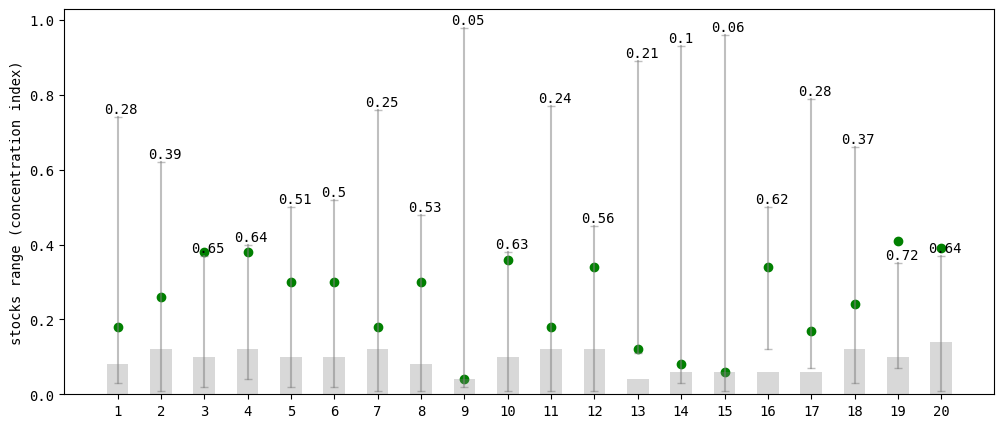

In [148]:
dis = []
xticks = []

plt.figure(figsize=(12, 5))

counter = 1
for resource_id in resources_decentralization.keys():
    dis.append(resources_decentralization[resource_id]["dec_index"])
    
    p1 = [counter, resources_decentralization[resource_id]["min_c"]]
    p2 = [counter, resources_decentralization[resource_id]["max_c"]]
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color="gray", marker='_', linestyle="-", alpha=0.5)
    plt.text(p2[0] - 0.30, p2[1] + 0.01, resources_decentralization[resource_id]["con_index"])

    plt.bar(counter, resources_decentralization[resource_id]["owners"] / len(agents), color="gray", alpha=0.3, width=0.5)

    xticks.append(counter)
    counter += 1

plt.scatter(xticks, dis, marker="o", color="green")# linestyle="-"
plt.ylabel("stocks range (concentration index)")
plt.xticks(xticks)
plt.show()


In [150]:
for agent_id, agent in agents.items():
    if "resource_18" in agent.inventory.stock.keys():
        print(agent_id, agent.inventory.stock["resource_18"]["quantity"])

agent_0 50
agent_1 19
agent_2 36
agent_3 26
agent_4 10
